# РЕКУРРЕНТНЫЕ СЕТИ В PyTorch




In [8]:
!pip install stop-words pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 72.3 kB/s eta 0:00:0000:0100:05

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [126]:
# попробуем запрограммировать простую рекурентную сеть. Возьмем датасет 

import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy3 import MorphAnalyzer
import re
import matplotlib.pyplot as plt
import time

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [127]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [128]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

# очистка текста от стоп-слов, пунктуации и служебных символов
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)


df_train["text"] = df_train["text"].apply(preprocess_text)
df_val["text"] = df_val["text"].apply(preprocess_text)
df_test["text"] = df_test["text"].apply(preprocess_text)

In [129]:
df_val["text"].iloc[:2]

0    rt tukvasociopat максимальный репост євромайда...
1    зп ежегодно индексировать индекс инфляция тари...
Name: text, dtype: object

In [123]:
# df_train.to_csv("data/train_preprocessed.csv", index=False)
# df_val.to_csv("data/val_preprocessed.csv", index=False)
# df_test.to_csv("data/test_preprocessed.csv", index=False)
# df_train = pd.read_csv("data/train_preprocessed.csv")
# df_test = pd.read_csv("data/test_preprocessed.csv")
# df_val = pd.read_csv("data/val_preprocessed.csv")

In [130]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter

In [131]:
text_corpus_train = df_train["text"].values
text_corpus_valid = df_val["text"].values
text_corpus_test = df_test["text"].values

counts = Counter()
for sequence in text_corpus_train:
    counts.update(sequence.split())

print("num_words before:", len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:", len(counts.keys()))

vocab2index = {"": 0, "UNK": 1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

num_words before: 258091
num_words after: 66109


Сборка датасета

In [132]:
from functools import lru_cache


class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, txts, labels, w2index, used_length):
        self._txts = txts
        self._labels = labels
        self._length = used_length
        self._w2index = w2index

    def __len__(self):
        return len(self._txts)

    def encode_sentence(self, txt):
        encoded = np.zeros(self._length, dtype=int)
        enc1 = np.array(
            [self._w2index.get(word, self._w2index["UNK"]) for word in txt.split()]
        )
        length = min(self._length, len(enc1))
        encoded[:length] = enc1[:length]
        return encoded, length

    def __getitem__(self, index):
        encoded, length = self.encode_sentence(self._txts[index])
        return torch.from_numpy(encoded.astype(np.int32)), self._labels[index], length

In [133]:
max([len(i.split()) for i in text_corpus_train])

27

In [134]:
y_train = df_train["class"].values
y_val = df_val["class"].values
num_workers = 0

train_dataset = TwitterDataset(text_corpus_train, y_train, vocab2index, 27)
valid_dataset = TwitterDataset(text_corpus_valid, y_val, vocab2index, 27)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=128, shuffle=False, num_workers=num_workers
)

документация : https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

Сборка модели:

объект класса RNN : RNN(embedding_dim, hidden_dim, num_layers=2, batch_first=True):

- embedding_dim -  длина вектора примера, 
- hidden_dim -  число нейронов==число выходов слоя, 
- num_layers -  число слоев , 
- batch_first=True -  число примеров в пакете первая размерность , т.е. тензор на входе "число примеров в пакете", "длина последовательности", "длина вектора примера"

Таким образом, на вход должен приходить 3хмерный тензор "число примеров, длина последовательности, размер вектора кода каждого элемента последовательности"

In [139]:
class RNNFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        rnn_out, ht = self.rnn(x)
        last_output = rnn_out[:, -1, :] 
        return self.linear(rnn_out)

In [140]:
rnn_init = RNNFixedLen(len(vocab2index), 30, 20)
optimizer = torch.optim.Adam(rnn_init.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [141]:
for epoch in range(10):
    rnn_init.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels, lengths = data[0], data[1], data[2]
        inputs = inputs.long()
        labels = labels.long().view(-1, 1)

        optimizer.zero_grad()

        outputs = rnn_init(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
    rnn_init.eval()
    loss_accumed = 0
    for X, y, lengths in valid_loader:
        X = X.long()
        y = y.long().view(-1, 1)
        output = rnn_init(X, lengths)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print("Training is finished!")

Epoch 0 valid_loss 121.35882568359375
Epoch 1 valid_loss 119.10755157470703
Epoch 2 valid_loss 118.6216049194336
Epoch 3 valid_loss 116.33831787109375
Epoch 4 valid_loss 115.86715698242188
Epoch 5 valid_loss 116.06468963623047
Epoch 6 valid_loss 114.39796447753906
Epoch 7 valid_loss 116.24295043945312
Epoch 8 valid_loss 116.15682983398438
Epoch 9 valid_loss 116.47637176513672
Training is finished!


In [109]:
del rnn_init

### **задание 1**

1.1 взять пример из ДЗ практики 7 и сформировать решение на torch

1.2 оценить связь - длина последовательности - качество для регрессиии (не менее 5 точек на график)

1.3 оценить связь - число примеров - качество для регрессиии (не менее 5 точек на график)

1.4* в среде с GPU оценить время работы той же задачи

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [85]:
# 1.1
def my_function(x):
    return np.log(x) / np.log(3) + np.log(x) - np.exp(x) / np.arctan(x)

def create_time_series_data(t, x, window_size=5, horizon=1, relative=True):
    N = len(t)
    X_list = []
    y_list = []
    
    for i in range(N - window_size - horizon):
        if relative:
            window = []
            for j in range(window_size - 1):
                window.append([
                    t[i+j] - t[i+window_size-1],
                    x[i+j] - x[i+window_size-1]
                ])
            window.append([t[i+window_size-1], x[i+window_size-1]])
        else:
            window = []
            for j in range(window_size):
                window.append([t[i+j], x[i+j]])
        
        X_list.append(window)
        y_list.append(x[i + window_size + horizon - 1])
    
    X = torch.FloatTensor(X_list)
    y = torch.FloatTensor(y_list)
    
    return X, y

In [99]:
class RNNFunc(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0.0, std=0.001)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
        nn.init.normal_(self.linear.weight, mean=0.0, std=0.001)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        rnn_out, ht = self.rnn(x)
        last_output = rnn_out[:, -1, :]
        return self.linear(last_output).squeeze()

In [100]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.001):
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
        
        if (epoch + 1) % 500 == 0:
            print(f'Epoch {epoch+1}: Train Loss = {loss.item():.6f}, Test Loss = {test_loss.item():.6f}')
    
    return train_losses, test_losses

In [101]:
N = 300
t_train = np.linspace(0.1, 0.75, N)
x_train = my_function(t_train)

t_test = np.linspace(0.75, 1.5, N)
x_test = my_function(t_test)

window_size = 5
horizon = 1

X_train, y_train = create_time_series_data(t_train, x_train, window_size, horizon, relative=True)
X_test, y_test = create_time_series_data(t_test, x_test, window_size, horizon, relative=True)

In [102]:
model = RNNFunc(input_size=2, hidden_dim=10, num_layers=2)
train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test, epochs=10000, lr=0.001)

Epoch 500: Train Loss = 8.257575, Test Loss = 1.874649
Epoch 1000: Train Loss = 6.279774, Test Loss = 6.998668
Epoch 1500: Train Loss = 6.260024, Test Loss = 7.665683
Epoch 2000: Train Loss = 2.077225, Test Loss = 1.151826
Epoch 2500: Train Loss = 0.725401, Test Loss = 2.829429
Epoch 3000: Train Loss = 0.319989, Test Loss = 3.890230
Epoch 3500: Train Loss = 0.118414, Test Loss = 2.436248
Epoch 4000: Train Loss = 0.056149, Test Loss = 2.143449
Epoch 4500: Train Loss = 0.029537, Test Loss = 1.936400
Epoch 5000: Train Loss = 0.016432, Test Loss = 1.600909
Epoch 5500: Train Loss = 0.009296, Test Loss = 1.197240
Epoch 6000: Train Loss = 0.005074, Test Loss = 0.826062
Epoch 6500: Train Loss = 0.002806, Test Loss = 0.587366
Epoch 7000: Train Loss = 0.001584, Test Loss = 0.438988
Epoch 7500: Train Loss = 0.000897, Test Loss = 0.341754
Epoch 8000: Train Loss = 0.000513, Test Loss = 0.281851
Epoch 8500: Train Loss = 0.000317, Test Loss = 0.248450
Epoch 9000: Train Loss = 0.000213, Test Loss = 0.

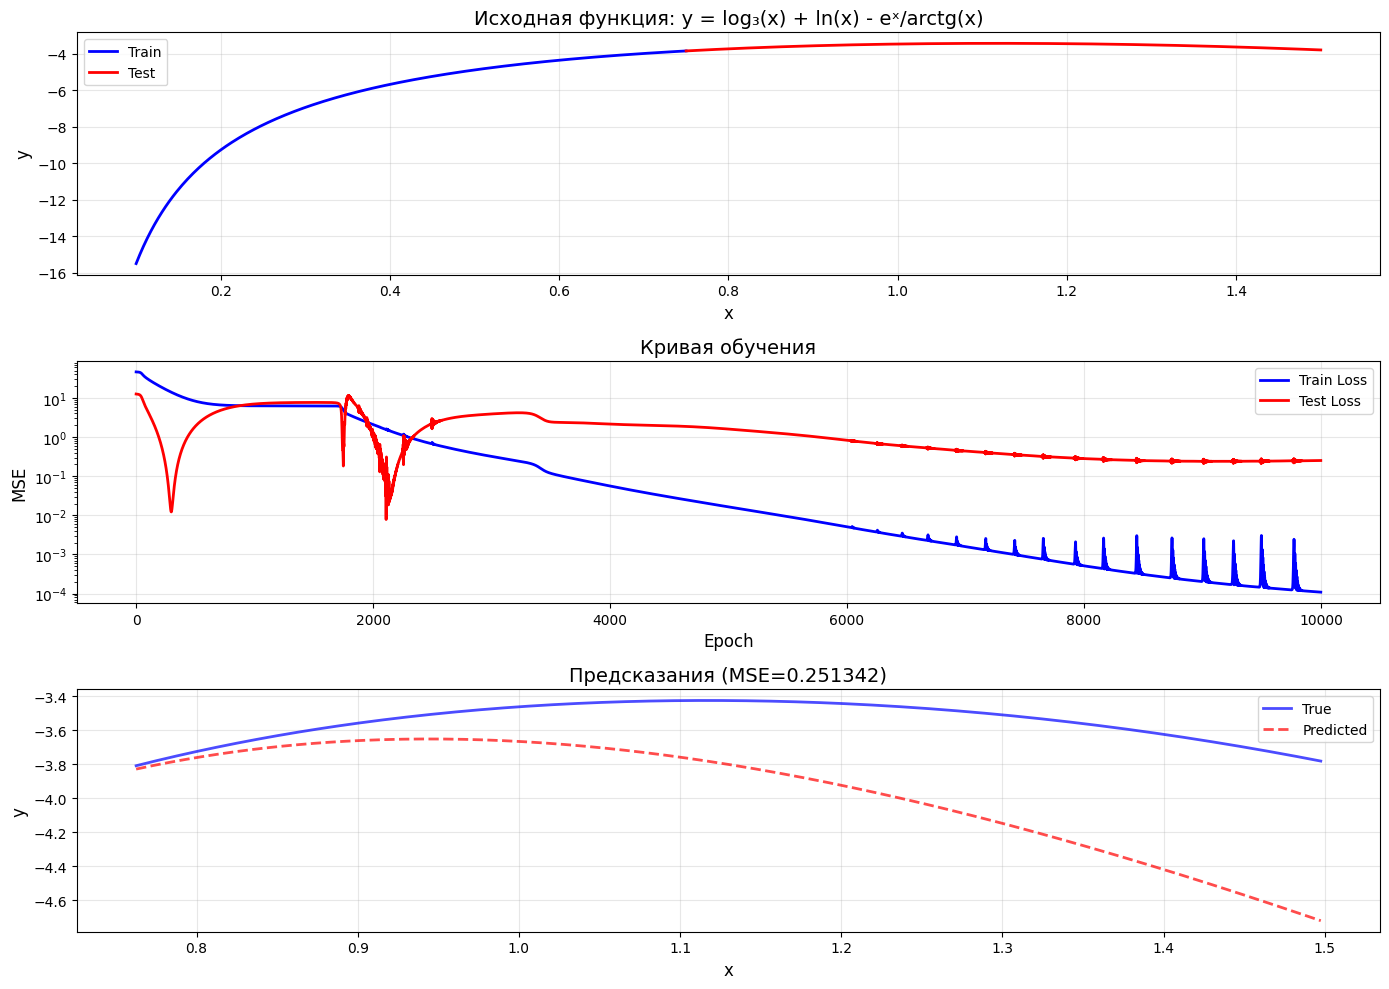

In [103]:
model.eval()
with torch.no_grad():
    predictions = model(X_test.to(device)).cpu().numpy()
    targets = y_test.cpu().numpy()

window_size, horizon = 5, 1
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(t_train, x_train, 'b-', linewidth=2, label='Train')
plt.plot(t_test, x_test, 'r-', linewidth=2, label='Test')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Исходная функция: y = log₃(x) + ln(x) - eˣ/arctg(x)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(train_losses, 'b-', linewidth=2, label='Train Loss')
plt.plot(test_losses, 'r-', linewidth=2, label='Test Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Кривая обучения', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(3, 1, 3)
test_x = t_test[window_size+horizon-1:window_size+horizon-1+len(targets)]
plt.plot(test_x, targets, 'b-', linewidth=2, label='True', alpha=0.7)
plt.plot(test_x, predictions, 'r--', linewidth=2, label='Predicted', alpha=0.7)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title(f'Предсказания (MSE={test_losses[-1]:.6f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Epoch 500: Train Loss = 9.054192, Test Loss = 1.957196
Epoch 1000: Train Loss = 6.928495, Test Loss = 7.367482
Epoch 1500: Train Loss = 3.286565, Test Loss = 3.514473
Epoch 2000: Train Loss = 1.213836, Test Loss = 11.082269
Epoch 2500: Train Loss = 0.622110, Test Loss = 10.133367
Epoch 3000: Train Loss = 0.367126, Test Loss = 8.422883
Epoch 3500: Train Loss = 0.234827, Test Loss = 6.554945
Epoch 4000: Train Loss = 0.118824, Test Loss = 2.463799
Epoch 4500: Train Loss = 0.027767, Test Loss = 0.176294
Epoch 5000: Train Loss = 0.013446, Test Loss = 0.182214
Epoch 500: Train Loss = 8.898452, Test Loss = 1.819072
Epoch 1000: Train Loss = 6.707845, Test Loss = 7.192428
Epoch 1500: Train Loss = 6.681408, Test Loss = 7.957581
Epoch 2000: Train Loss = 1.940684, Test Loss = 9.530783
Epoch 2500: Train Loss = 0.800477, Test Loss = 10.670889
Epoch 3000: Train Loss = 0.384301, Test Loss = 6.151196
Epoch 3500: Train Loss = 0.126395, Test Loss = 0.258822
Epoch 4000: Train Loss = 0.058292, Test Loss = 

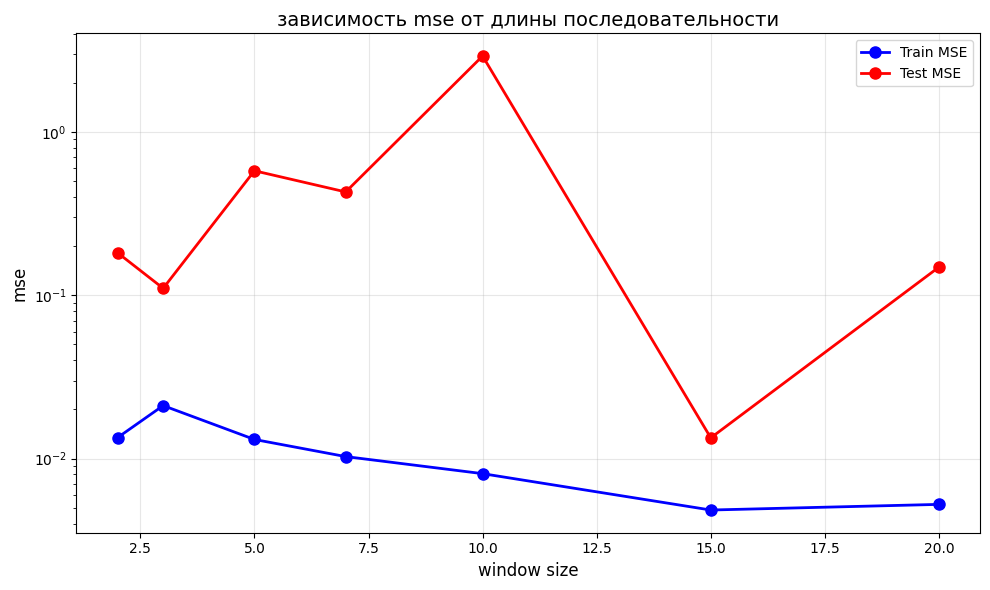

In [114]:
# 1.2
hidden_dim = 10
horizon = 1
window_sizes = [2, 3, 5, 7, 10, 15, 20]

train_mses_ws = []
test_mses_ws = []

torch.manual_seed(42)

for ws in window_sizes:
    X_train, y_train = create_time_series_data_torch(t_train, x_train, ws, horizon)
    X_test, y_test = create_time_series_data_torch(t_test, x_test, ws, horizon)
    
    model = RNNFunc(input_size=2, hidden_dim=hidden_dim, num_layers=2)
    train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test, epochs=5000, lr=0.001)
    
    train_mses_ws.append(train_losses[-1])
    test_mses_ws.append(test_losses[-1])

plt.figure(figsize=(10, 6))
plt.plot(window_sizes, train_mses_ws, 'bo-', linewidth=2, markersize=8, label='Train MSE')
plt.plot(window_sizes, test_mses_ws, 'ro-', linewidth=2, markersize=8, label='Test MSE')
plt.xlabel('window size', fontsize=12)
plt.ylabel('mse', fontsize=12)
plt.title('зависимость mse от длины последовательности', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

#### Вывод по связи качества регрессии от длины последовательности: 

1. Из графиков виднно, что при window size = 15, ошибка на train, так и на test минимальна - то есть RNN лучше всего работает с контекстом средней длины.
2. Для маленького контекста (2-5) модель запоминает короткие паттерны из-за чего плохо предсказывает на test.
3. Контекст длины 10 - худший результат на train, но на test нормально и лучше чем для маленьких window size.: 

1. Из графиков виднно, что при window size = 15, ошибка на train, так и на test минимальна - то есть RNN лучше всего работает с контекстом средней длины.
2. Для маленького контекста (2-5) модель запоминает короткие паттерны из-за чего плохо предсказывает на test.
3. Контекст длины 10 - худший результат на train, но на test нормально и лучше чем для маленьких window size.

Epoch 500: Train Loss = 1.147442, Test Loss = 0.722313
Epoch 1000: Train Loss = 0.781259, Test Loss = 2.058466
Epoch 1500: Train Loss = 0.780978, Test Loss = 2.099852
Epoch 2000: Train Loss = 0.780823, Test Loss = 2.099414
Epoch 2500: Train Loss = 0.780193, Test Loss = 2.096648
Epoch 3000: Train Loss = 0.225071, Test Loss = 60.104946
Epoch 3500: Train Loss = 0.007676, Test Loss = 0.086936
Epoch 4000: Train Loss = 0.001057, Test Loss = 0.023163
Epoch 4500: Train Loss = 0.000308, Test Loss = 0.024241
Epoch 5000: Train Loss = 0.000099, Test Loss = 0.016015
Epoch 500: Train Loss = 2.996937, Test Loss = 1.154176
Epoch 1000: Train Loss = 2.147335, Test Loss = 3.787486
Epoch 1500: Train Loss = 2.144965, Test Loss = 3.959626
Epoch 2000: Train Loss = 2.142205, Test Loss = 3.949858
Epoch 2500: Train Loss = 0.434289, Test Loss = 2.043141
Epoch 3000: Train Loss = 0.048848, Test Loss = 0.687167
Epoch 3500: Train Loss = 0.013706, Test Loss = 0.549749
Epoch 4000: Train Loss = 0.004782, Test Loss = 0.

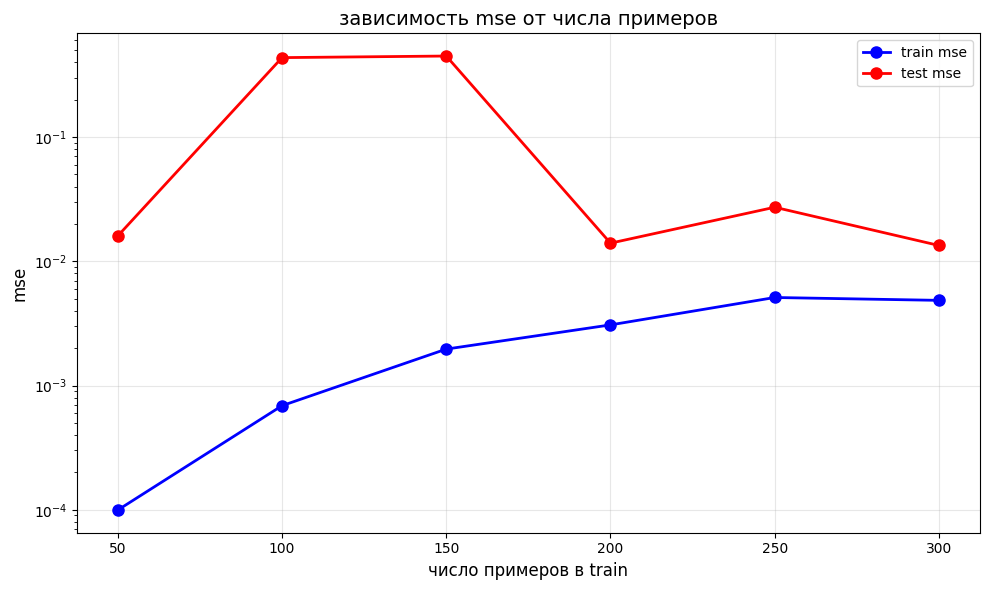

In [115]:
# 1.3
window_size = 15
n_samples_list = [50, 100, 150, 200, 250, 300]

train_mses_ns = []
test_mses_ns = []

torch.manual_seed(42)

for n_samples in n_samples_list:
    t_train_temp = np.linspace(0.1, 0.75, n_samples)
    x_train_temp = my_function(t_train_temp)
    
    X_train, y_train = create_time_series_data_torch(t_train_temp, x_train_temp, window_size, horizon)
    X_test, y_test = create_time_series_data_torch(t_test, x_test, window_size, horizon)

    model = RNNFunc(input_size=2, hidden_dim=10, num_layers=2)
    train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test, epochs=5000, lr=0.001)
    
    train_mses_ns.append(train_losses[-1])
    test_mses_ns.append(test_losses[-1])

plt.figure(figsize=(10, 6))
plt.plot(n_samples_list, train_mses_ns, 'bo-', linewidth=2, markersize=8, label='train mse')
plt.plot(n_samples_list, test_mses_ns, 'ro-', linewidth=2, markersize=8, label='test mse')
plt.xlabel('число примеров в train', fontsize=12)
plt.ylabel('mse', fontsize=12)
plt.title('зависимость mse от числа примеров', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

#### Вывод по связи качества регрессии от числа примеров: 

1. Loss для train растёт - монотонно возрастающая функция, что нормально, т.к. чем больше данных, тем сложнее верно предсказать точное значение функции для всех моментов времени t. Однако, возможно, большое число примеров обвалит train loss.
2. Однако обобщающая способность закономерно улучшается от числа примеров - в 100 и 150 плато, но зато потом падает.
3. Число примеров > 200 будет наилучшим выбором.

In [110]:
# 1.4
window_size = 5
epochs = 1000

X_train, y_train = create_time_series_data(t_train, x_train, window_size, horizon)
X_test, y_test = create_time_series_data(t_test, x_test, window_size, horizon)

model_cpu = RNNFunc(input_size=2, hidden_dim=10, num_layers=2)
device_cpu = torch.device('cpu')

start_time = time.time()
_ = train_model(model_cpu.to(device_cpu), X_train.to(device_cpu), y_train.to(device_cpu), 
                X_test.to(device_cpu), y_test.to(device_cpu), epochs=epochs, lr=0.001)

cpu_time = time.time() - start_time
print(f"время CPU: {cpu_time} секунд")

if torch.cuda.is_available():
    model_gpu = RNNFunc(input_size=2, hidden_dim=10, num_layers=2)
    device_gpu = torch.device('cuda')
    
    start_time = time.time()
    _ = train_model(model_gpu.to(device_gpu), X_train.to(device_gpu), y_train.to(device_gpu), 
                    X_test.to(device_gpu), y_test.to(device_gpu), epochs=epochs, lr=0.001)
    
    gpu_time = time.time() - start_time
    print(f"время GPU: {gpu_time} секунд")
    print(f"Прирост в скорости в {cpu_time/gpu_time} раз")

else:
    print("GPU недоступен. Используйте Google Colab с GPU.")

### **задание 2**

2.1 Подобрать параметры решения задачи классификации твитов в RNN


In [142]:
def train_model_twt(model, train_loader, valid_loader, epochs, lr):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    valid_losses = []
    
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels, lengths = data[0], data[1], data[2]
            inputs = inputs.long().to(device)
            labels = labels.long().view(-1, 1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
     
        model.eval()
        loss_accumed = 0
        with torch.no_grad():
            for X, y, lengths in valid_loader:
                X = X.long().to(device)
                y = y.long().view(-1, 1).to(device)
                output = model(X, lengths)
                loss = criterion(output, y)
                loss_accumed += loss.item()
        
        valid_losses.append(loss_accumed)
    
    return valid_losses

In [144]:
embedding_dims = [30, 50, 100]
hidden_dims = [20, 50, 100]
learning_rates = [0.0001, 0.001, 0.01]

best_loss = float('inf')
best_params = {}

seq_length = 27
batch_size = 128
epochs = 10
num_workers = 0

for emb_dim in embedding_dims:
    for hid_dim in hidden_dims:
        for lr in learning_rates:
            train_dataset = TwitterDataset(text_corpus_train, y_train, vocab2index, seq_length)
            valid_dataset = TwitterDataset(text_corpus_valid, y_val, vocab2index, seq_length)
            
            train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
            )
            valid_loader = torch.utils.data.DataLoader(
                valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
            )
            
            model = RNNFixedLen(len(vocab2index), emb_dim, hid_dim)
            valid_losses = train_model_twt(model, train_loader, valid_loader, epochs, lr)
            
            final_valid_loss = valid_losses[-1]
            
            if final_valid_loss < best_loss:
                best_loss = final_valid_loss
                best_params = {
                    'embedding_dim': emb_dim,
                    'hidden_dim': hid_dim,
                    'lr': lr
                }
            
            print(f"emb={emb_dim}, hid={hid_dim}, lr={lr}: loss={final_valid_loss}")

emb=30, hid=20, lr=0.0001: loss=120.50108033418655
emb=30, hid=20, lr=0.001: loss=115.54512244462967
emb=30, hid=20, lr=0.01: loss=127.880735039711
emb=30, hid=50, lr=0.0001: loss=120.16611760854721
emb=30, hid=50, lr=0.001: loss=114.90591144561768
emb=30, hid=50, lr=0.01: loss=124.2212125658989
emb=30, hid=100, lr=0.0001: loss=119.77758014202118
emb=30, hid=100, lr=0.001: loss=115.31211268901825
emb=30, hid=100, lr=0.01: loss=123.94333666563034
emb=50, hid=20, lr=0.0001: loss=119.09081602096558
emb=50, hid=20, lr=0.001: loss=116.52976244688034
emb=50, hid=20, lr=0.01: loss=130.76799821853638
emb=50, hid=50, lr=0.0001: loss=119.05088657140732
emb=50, hid=50, lr=0.001: loss=117.49814611673355
emb=50, hid=50, lr=0.01: loss=125.62763929367065
emb=50, hid=100, lr=0.0001: loss=118.76795774698257
emb=50, hid=100, lr=0.001: loss=115.59626060724258
emb=50, hid=100, lr=0.01: loss=123.08928418159485
emb=100, hid=20, lr=0.0001: loss=118.27104085683823
emb=100, hid=20, lr=0.001: loss=117.452577710

In [145]:
print(best_params)

{'embedding_dim': 30, 'hidden_dim': 50, 'lr': 0.001}


In [147]:
print(best_loss)

114.90591144561768


#  Проблемы у рекурентных сетей


Можно представить разные моменты времени с разными слоями. У всех слоев одни и те же веса. Соответсвенно, проходясь обратным распространением по этим сетям все это вместе складываем и применяем. Так происходит обучение.  

То что произошло в начале последовательности, может повлиять на то, что произойдет в конце этой последовательности. И tanh -  исчезновение градиента. 
Резюме:
- затухают градиенты
- медленно, нужно всегда дойти до конца

Как решить? -> LSTM

[оригинальная статья. 1997](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory)

Автор статьи [Юрген Шмидхубер](https://ru.wikipedia.org/wiki/%D0%A8%D0%BC%D0%B8%D0%B4%D1%85%D1%83%D0%B1%D0%B5%D1%80,_%D0%AE%D1%80%D0%B3%D0%B5%D0%BD). Первая реализации ее случилась только после несколько лет после ее публикации.

[статья](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), которая объясняет что там происходит

[перевод](https://alexsosn.github.io/ml/2015/11/17/LSTM.html) статьи выше

<img src="images/lstm.png">


https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Как это работает:


<img src="images/LSTMMaths.png">



Основная идея.  

Теперь на каждом шаге передаем не один вектор, а два. Один из них (нижний) - это то самый h, который пойдет на вход следующему слою. А кроме этого, будем передавать, так называемое self-state - с. h будет проходить через много нелинейностей, умножаться на матрицы и будет испытывать ГРАДИЕНТНЫЙ ВЗРЫВ и ЗАТУХАНИЕ ГРАДИЕНТА.  

А С будет как можно больше напрямую передаваться из прошлого состояния в следующее. По нему будем очень аккуратно делать апдейты, что бы он очень плавно перетекал из одного состояния в другое.  

### 2.1 Как это выглядит подробнее:  

Внутри есть мнгого разных гейтов - некоторый вектор коэффициентов, которые соответсвуют той же размерности что и вход на них.  


#### **Forget gate**

Первый шаг в LSTM - это решить, от какой информации хотим избавиться. Это решение принимает слой с сигмоидой, который называется "forget gate layer." (гейт забывания). Он принимает во внимание $h_{t−1}$ и $x_t$, а на выходе даёт значение между 0 и 1 для каждого числа в состоянии ячейки $C_{t−1}$. 1 значит "полностью сохрани это", а 0 - "полностью забудь это".

Пример забывания - языковая модель пытается предсказать следующее слово базируясь на предыдущих. Здесь модель может запоминать род объекта, чтобы использовать правильное образование слов. Когда видим новый объект, то нужно забыть род предыдущего объекта. *(Животное не переходило дорогу, потому что оно устало)*

#### **Input gate**

Следующий шаг - решить, какую информацию должны хранить в состоянии ячейки. Шаг состоит из двух частей. Первая - слой сигмоиды, называемый "input gate layer" (входной гейт), который решает какие значения будут обновляться. Вторая - слой с тангенсом, который создает вектор значений $\tilde{C}_t$, которые будут добавляться к состоянию ячейки. Используем tanh, потому что нам хочется что бы эта добавка могла пойти и в + и в -.


С примером языковой модели, хотели бы добавлять род нового объекта в состояние ячейки, чтобы заменить старый род, который мы забудем. *(Животное не переходило дорогу, потому что оно устало)*

#### **Update cell state**

Сейчас самое время, чтобы обновить старое состояние $C_{t−1}$ в новое состояние $C_t$. Предыдущие шаги уже решили, что делать, нужно только сделать это.

Умножаем старое состояние на $f_t$, тем самым забывая те вещи, которые хотели забыть, затем прибавляем $i_t∗\tilde{C_t}$. Это новое значение состояния ячейки, которое отмасштабировано в зависимоcти от того, насколько мы хотим обновить новое значение.

В языковой модели, это момент, где мы выкидываем информацию о роде старого объекта и добавляем новую информацию о роде нового объекта. *(Животное не переходило дорогу, потому что оно устало)*

#### **Output gate**

Выход будет базироваться на состоянии ячейки, но с небольшой фильтрацией. Во-первых, прогоним входной сигнал через сигмоиду, которая решает с какой силой дальше пропускать сигнал, во-вторых, прогоняем состояние ячейки через тангенс и умножаем это на сигмоиду, чтобы пропускать дальше только то, что  решили пропустить.


Для языковой модели, которая видит только объект, здесь можем пропустить информацию, связанную с глаголом. Например, на выходе может быть полезно число множественной или единственное у объекта, чтобы знать в какую форму нужно поставить глагол. *(Животное не переходило дорогу, потому что оно устало)*

Основная идея - на следующий шаг передавали два вектора. Один из них h в процессе своего формирования прошел через огромное количество нелинейностей, одних и тех же весов, второй - обходной путь С.  

документация : https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# rnn_init.to(device)
device = "cpu"

In [17]:
class LSTMFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x) # возратит выход и (состояние нейронов - h , self-state - С)
        return self.linear(lstm_out)


lstm_init = LSTMFixedLen(len(vocab2index), 128, 20).to(device)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [18]:
output.shape, y.shape

(torch.Size([27, 27, 1]), torch.Size([27, 1]))

In [20]:
th = 0
test_loss_history = []
for epoch in range(10):
    lstm_init.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels, lengths = data[0], data[1], data[2]
        inputs = inputs.long().to(device)
        labels = labels.long().view(-1, 1).to(device)

        optimizer.zero_grad()

        outputs = lstm_init(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    lstm_init.eval()
    loss_accumed = 0
    test_running_total = 0
    test_running_right = 0
    for X, y, lengths in valid_loader:
        X = X.long().to(device)
        y = y.long().view(-1, 1).to(device)
        output = lstm_init(X, lengths)
        loss = criterion(output, y)
        test_running_total += 1
        loss_accumed += loss
        pred_test_labels = torch.squeeze((output > th).int())
        test_running_right += ((y == pred_test_labels).float()).mean()

        test_loss_history.append(loss.item())
    print(f"Test acc: {test_running_right / test_running_total}")
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed / test_running_total))

print("Training is finished!")

Test acc: 0.4980042576789856
Epoch 0 valid_loss 1.2115055322647095
Test acc: 0.49797648191452026
Epoch 1 valid_loss 0.8758102655410767
Test acc: 0.4977433383464813
Epoch 2 valid_loss 0.795535683631897
Test acc: 0.4979219436645508
Epoch 3 valid_loss 0.7438960671424866
Test acc: 0.4977138340473175
Epoch 4 valid_loss 0.710970401763916
Test acc: 0.4976184368133545
Epoch 5 valid_loss 0.6917902827262878
Test acc: 0.49737733602523804
Epoch 6 valid_loss 0.6792450547218323
Test acc: 0.49744412302970886
Epoch 7 valid_loss 0.6758008599281311
Test acc: 0.4973856508731842
Epoch 8 valid_loss 0.6691483855247498
Test acc: 0.49741801619529724
Epoch 9 valid_loss 0.6655113101005554
Training is finished!


In [22]:
del lstm_init
torch.cuda.empty_cache()

### **задание 3**
для задачи анализа Твитов:
3.1 оценить связь - чисоло слоев - качество модели

3.2 оценить связь - число нейронов - качество модели

3.3* в среде с GPU оценить время работы той же задачи

3.4* Подобрать параметры решения задачи классификации твитов в LSTM

In [148]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [149]:
class LSTMTask3(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(lstm_out)

In [150]:
def train_lstm(model, train_loader, valid_loader, epochs, lr, verbose=False):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    th = 0
    valid_losses = []
    valid_accs = []
    
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels, lengths = data[0], data[1], data[2]
            inputs = inputs.long().to(device)
            labels = labels.long().view(-1, 1).to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        loss_accumed = 0
        test_running_total = 0
        test_running_right = 0
        
        with torch.no_grad():
            for X, y, lengths in valid_loader:
                X = X.long().to(device)
                y = y.long().view(-1, 1).to(device)
                output = model(X, lengths)
                loss = criterion(output, y)
                test_running_total += 1
                loss_accumed += loss.item()
                pred_test_labels = torch.squeeze((output > th).int())
                test_running_right += ((y == pred_test_labels).float()).mean().item()
        
        avg_loss = loss_accumed / test_running_total
        avg_acc = test_running_right / test_running_total
        
        valid_losses.append(avg_loss)
        valid_accs.append(avg_acc)
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}: Valid Loss = {avg_loss:.4f}, Valid Acc = {avg_acc:.4f}")
    
    return valid_losses, valid_accs

In [151]:
seq_length = 27
batch_size = 128
num_workers = 0

train_dataset = TwitterDataset(text_corpus_train, y_train, vocab2index, seq_length)
valid_dataset = TwitterDataset(text_corpus_valid, y_val, vocab2index, seq_length)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [152]:
# 3.1
num_layers_list = [1, 2, 3, 4, 5]
embedding_dim = 128
hidden_dim = 50
lr = 0.0001
epochs = 5

results_layers = []

for num_layers in num_layers_list:
    model = LSTMTask3(len(vocab2index), embedding_dim, hidden_dim, num_layers=num_layers)
    
    valid_losses, valid_accs = train_lstm(model, train_loader, valid_loader, epochs, lr, verbose=True)
    
    results_layers.append({
        'num_layers': num_layers,
        'final_loss': valid_losses[-1],
        'final_acc': valid_accs[-1],
        'valid_losses': valid_losses,
        'valid_accs': valid_accs
    })
    
    del model
    torch.cuda.empty_cache()

Epoch 5: Valid Loss = 0.6664, Valid Acc = 0.4972
Epoch 5: Valid Loss = 0.6603, Valid Acc = 0.4976
Epoch 5: Valid Loss = 0.6633, Valid Acc = 0.4976
Epoch 5: Valid Loss = 0.6632, Valid Acc = 0.4972
Epoch 5: Valid Loss = 0.6594, Valid Acc = 0.4976


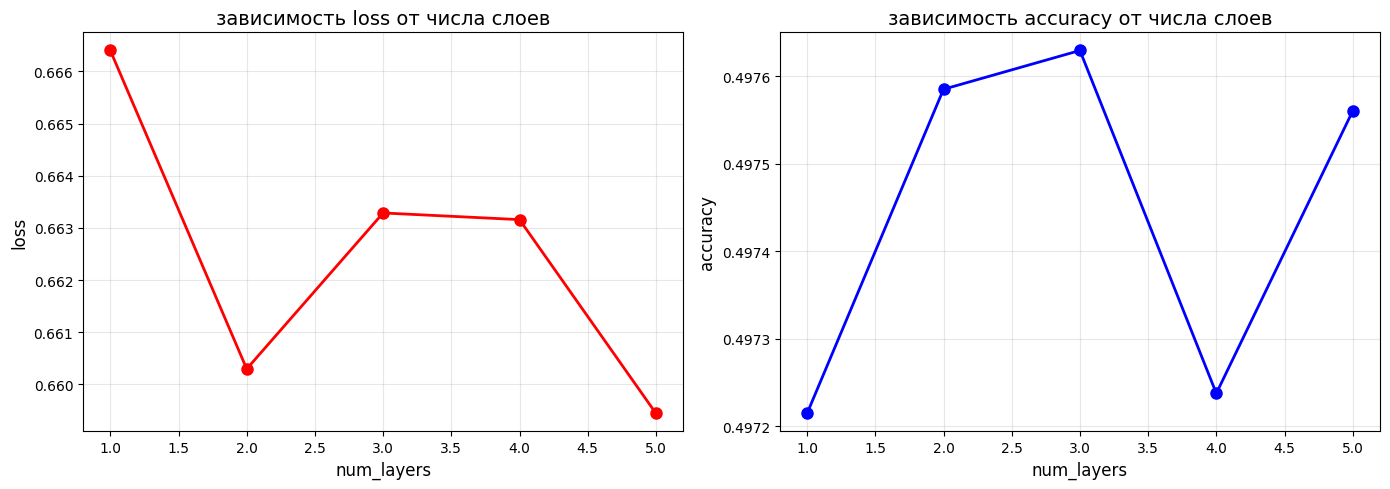

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

layers = [r['num_layers'] for r in results_layers]
losses = [r['final_loss'] for r in results_layers]
accs = [r['final_acc'] for r in results_layers]

axes[0].plot(layers, losses, 'ro-', linewidth=2, markersize=8)
axes[0].set_xlabel('num_layers', fontsize=12)
axes[0].set_ylabel('loss', fontsize=12)
axes[0].set_title('зависимость loss от числа слоев', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].plot(layers, accs, 'bo-', linewidth=2, markersize=8)
axes[1].set_xlabel('num_layers', fontsize=12)
axes[1].set_ylabel('accuracy', fontsize=12)
axes[1].set_title('зависимость accuracy от числа слоев', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [154]:
# 3.2
hidden_dims_list = [10, 20, 50, 100, 150, 200]
embedding_dim = 128
num_layers = 2
lr = 0.0001
epochs = 5

results_neurons = []

for hidden_dim in hidden_dims_list:    
    model = LSTMTask3(len(vocab2index), embedding_dim, hidden_dim, num_layers=num_layers)
    
    valid_losses, valid_accs = train_lstm(model, train_loader, valid_loader, epochs, lr, verbose=True)
    
    results_neurons.append({
        'hidden_dim': hidden_dim,
        'final_loss': valid_losses[-1],
        'final_acc': valid_accs[-1],
        'valid_losses': valid_losses,
        'valid_accs': valid_accs
    })
    
    del model
    torch.cuda.empty_cache()

Epoch 5: Valid Loss = 0.7023, Valid Acc = 0.4966
Epoch 5: Valid Loss = 0.6747, Valid Acc = 0.4967
Epoch 5: Valid Loss = 0.6700, Valid Acc = 0.4980
Epoch 5: Valid Loss = 0.6592, Valid Acc = 0.4977
Epoch 5: Valid Loss = 0.6614, Valid Acc = 0.4980
Epoch 5: Valid Loss = 0.6551, Valid Acc = 0.4980


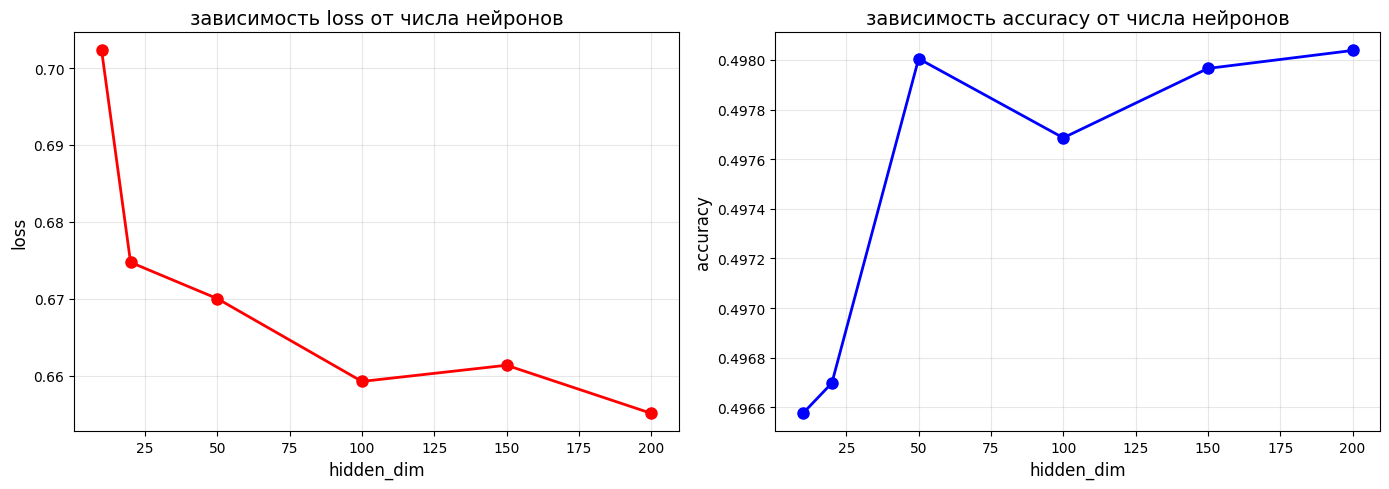

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

neurons = [r['hidden_dim'] for r in results_neurons]
losses = [r['final_loss'] for r in results_neurons]
accs = [r['final_acc'] for r in results_neurons]

axes[0].plot(neurons, losses, 'ro-', linewidth=2, markersize=8)
axes[0].set_xlabel('hidden_dim', fontsize=12)
axes[0].set_ylabel('loss', fontsize=12)
axes[0].set_title('зависимость loss от числа нейронов', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].plot(neurons, accs, 'bo-', linewidth=2, markersize=8)
axes[1].set_xlabel('hidden_dim', fontsize=12)
axes[1].set_ylabel('accuracy', fontsize=12)
axes[1].set_title('зависимость accuracy от числа нейронов', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 3.3
embedding_dim = 128
hidden_dim = 50
num_layers = 2
lr = 0.0001
epochs = 5

device_cpu = torch.device('cpu')
model_cpu = LSTMTask3(len(vocab2index), embedding_dim, hidden_dim, num_layers=num_layers)

train_loader_cpu = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader_cpu = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

start_time = time.time()

old_device = device
device = device_cpu
valid_losses_cpu, valid_accs_cpu = train_lstm(model_cpu, train_loader_cpu, valid_loader_cpu, epochs, lr)

device = old_device
cpu_time = time.time() - start_time

print(f"время на cpu: {cpu_time} секунд")
del model_cpu

if torch.cuda.is_available():
    device_gpu = torch.device('cuda')
    model_gpu = LSTMTask3(len(vocab2index), embedding_dim, hidden_dim, num_layers=num_layers)
    
    start_time = time.time()
    old_device = device
    device = device_gpu
    valid_losses_gpu, valid_accs_gpu = train_lstm(model_gpu, train_loader, valid_loader, epochs, lr)
    device = old_device
    gpu_time = time.time() - start_time
    
    print(f"время GPU: {gpu_time} секунд")
    print(f"прирост скорости в: {cpu_time/gpu_time} раз")
    
    del model_gpu
    torch.cuda.empty_cache()
else:
    print("GPU недоступен")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [156]:
# 3.4
embedding_dims = [64, 128, 256]
hidden_dims = [20, 50, 100]
learning_rates = [0.0001, 0.001]

results_grid = []
best_acc = 0
best_params = {}

epochs = 5

for emb_dim in embedding_dims:
    for hid_dim in hidden_dims:
        for lr in learning_rates:
            model = LSTMTask3(len(vocab2index), emb_dim, hid_dim, num_layers=2)
            
            valid_losses, valid_accs = train_lstm(model, train_loader, valid_loader, epochs, lr, verbose=False)
            
            final_acc = valid_accs[-1]
            final_loss = valid_losses[-1]
            
            if final_acc > best_acc:
                best_acc = final_acc
                best_params = {
                    'embedding_dim': emb_dim,
                    'hidden_dim': hid_dim,
                    'lr': lr
                }
            
            print(f"emb_dim: {emb_dim}; hid_dim: {hid_dim}; lr: {lr}; accuracy: {final_acc} loss: {final_loss:.4f}")
            
            del model
            torch.cuda.empty_cache()

emb_dim: 64; hid_dim: 20; lr: 0.0001; accuracy: 0.49623138181279214 loss: 0.6816
emb_dim: 64; hid_dim: 20; lr: 0.001; accuracy: 0.4974115485890528 loss: 0.6458
emb_dim: 64; hid_dim: 50; lr: 0.0001; accuracy: 0.4969840215498142 loss: 0.6736
emb_dim: 64; hid_dim: 50; lr: 0.001; accuracy: 0.49901520485958356 loss: 0.6417
emb_dim: 64; hid_dim: 100; lr: 0.0001; accuracy: 0.4973099199908503 loss: 0.6691
emb_dim: 64; hid_dim: 100; lr: 0.001; accuracy: 0.5029689570826091 loss: 0.6450
emb_dim: 128; hid_dim: 20; lr: 0.0001; accuracy: 0.4964930982737059 loss: 0.6758
emb_dim: 128; hid_dim: 20; lr: 0.001; accuracy: 0.49787399373697433 loss: 0.6458
emb_dim: 128; hid_dim: 50; lr: 0.0001; accuracy: 0.4975082395451792 loss: 0.6640
emb_dim: 128; hid_dim: 50; lr: 0.001; accuracy: 0.5007980352037409 loss: 0.6495
emb_dim: 128; hid_dim: 100; lr: 0.0001; accuracy: 0.4980255914538094 loss: 0.6602
emb_dim: 128; hid_dim: 100; lr: 0.001; accuracy: 0.5029194666428513 loss: 0.6529
emb_dim: 256; hid_dim: 20; lr: 0.

In [157]:
print(best_params)

{'embedding_dim': 64, 'hidden_dim': 100, 'lr': 0.001}


In [158]:
print(best_acc)

0.5029689570826091


##  **Какие проблемы:**



Резюме:

- вычислительно сложно -> медленнее
- на очень длинных последовательностях все равно затухает градиент


уберем некоторые гейты (точнее совместим) -> ускоримся, уменьшим число параметров -> GRU

## GRU

<img src="images/gru.png">


GRU Math


<img src="images/GRUMath.png">


In [34]:
class GRUFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x, l):
        n = x.shape[0]
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, (ht, ct) = self.gru(x)
        return nn.functional.sigmoid(self.linear(gru_out[:,-1, :]))

device = 'cpu'
gru_init = GRUFixedLen(len(vocab2index), 64, 2).to(device)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.0001)
criterion = nn.BCELoss()

In [35]:
th = 0
device = 'cpu'
training_loop_stream = torch.cuda.Stream()
torch.cuda.synchronize() # make sure model is on device
with torch.cuda.stream(training_loop_stream):
    for epoch in range(10):
        gru_init.train()
        device = 'cpu'
        for i, data in enumerate(train_loader, 0):
            device = 'cpu'
            inputs, labels, lengths = data[0], data[1], data[2]
            inputs = inputs.long().to(device)
            labels = labels.float().view(-1, 1).to(device)

            optimizer.zero_grad()
            

            outputs = gru_init(inputs, lengths)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()

        gru_init.eval()
        loss_accumed = 0
        test_running_total = 0
        test_running_right = 0
        for X, y, lengths in valid_loader:
            X = X.long().to(device)
            y = y.long().view(-1, 1).to(device)
            output = gru_init(X, lengths)
            loss = criterion(output.float(), y.float())
            loss_accumed += loss
            test_running_total += 1
            pred_test_labels = torch.squeeze((output > th).int())
            test_running_right += ((y == pred_test_labels).float()).mean()

            test_loss_history.append(loss.item())
        print(f"Test acc: {test_running_right / test_running_total:.3f}")
        print("Epoch {} valid_loss {}".format(epoch, loss_accumed / test_running_total))


    print("Training is finished!")

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test acc: 0.505
Epoch 0 valid_loss 0.6933483481407166
Test acc: 0.505
Epoch 1 valid_loss 0.6931113004684448
Test acc: 0.505
Epoch 2 valid_loss 0.6930837035179138
Test acc: 0.505
Epoch 3 valid_loss 0.6930277347564697
Test acc: 0.505
Epoch 4 valid_loss 0.692570686340332
Test acc: 0.505
Epoch 5 valid_loss 0.6898223161697388
Test acc: 0.505
Epoch 6 valid_loss 0.6774609088897705
Test acc: 0.505
Epoch 7 valid_loss 0.6580951809883118
Test acc: 0.505
Epoch 8 valid_loss 0.6509857773780823
Test acc: 0.505
Epoch 9 valid_loss 0.6460574269294739
Training is finished!


In [36]:
outputs.mean()

tensor(0.5097, grad_fn=<MeanBackward0>)

### **задание 4**
для задачи анализа Твитов:
4.1 оценить связь - чисоло слоев - качество модели

4.2 оценить связь - число нейронов - качество модели

4.3* в среде с GPU оценить время работы той же задачи
4.4* Подобрать параметры решения задачи классификации твитов в GRU

In [159]:
class GRUTask4(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
        return nn.functional.sigmoid(self.linear(gru_out[:, -1, :]))

In [160]:
def train_gru(model, train_loader, valid_loader, epochs, lr, verbose=False):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    th = 0
    valid_losses = []
    valid_accs = []
    
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels, lengths = data[0], data[1], data[2]
            inputs = inputs.long().to(device)
            labels = labels.float().view(-1, 1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()

        model.eval()
        loss_accumed = 0
        test_running_total = 0
        test_running_right = 0
        
        with torch.no_grad():
            for X, y, lengths in valid_loader:
                X = X.long().to(device)
                y = y.long().view(-1, 1).to(device)
                output = model(X, lengths)
                loss = criterion(output.float(), y.float())
                loss_accumed += loss.item()
                test_running_total += 1
                pred_test_labels = torch.squeeze((output > th).int())
                test_running_right += ((y == pred_test_labels).float()).mean().item()

        avg_loss = loss_accumed / test_running_total
        avg_acc = test_running_right / test_running_total
        
        valid_losses.append(avg_loss)
        valid_accs.append(avg_acc)
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch}: Valid Loss = {avg_loss:.4f}, Acc = {avg_acc:.3f}")
    
    return valid_losses, valid_accs

In [161]:
seq_length = 27
batch_size = 128
num_workers = 0

train_dataset = TwitterDataset(text_corpus_train, y_train, vocab2index, seq_length)
valid_dataset = TwitterDataset(text_corpus_valid, y_val, vocab2index, seq_length)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [162]:
# 4.1
num_layers_list = [1, 2, 3, 4, 5]
embedding_dim = 64
hidden_dim = 50
lr = 0.0001
epochs = 5

results_layers = []

for num_layers in num_layers_list:
    model = GRUTask4(len(vocab2index), embedding_dim, hidden_dim, num_layers=num_layers)
    
    valid_losses, valid_accs = train_gru(model, train_loader, valid_loader, epochs, lr, verbose=True)
    
    results_layers.append({
        'num_layers': num_layers,
        'final_loss': valid_losses[-1],
        'final_acc': valid_accs[-1],
        'valid_losses': valid_losses,
        'valid_accs': valid_accs
    })
    
    print(f"num_layers={num_layers}; loss={valid_losses[-1]}, accuracy={valid_accs[-1]}")
    
    del model
    torch.cuda.empty_cache()

Epoch 4: Valid Loss = 0.5750, Acc = 0.505
num_layers=1; loss=0.5749863799703255, accuracy=0.5051286803202683
Epoch 4: Valid Loss = 0.5718, Acc = 0.505
num_layers=2; loss=0.5717689398299443, accuracy=0.5051286803202683
Epoch 4: Valid Loss = 0.5661, Acc = 0.505
num_layers=3; loss=0.5661245072155856, accuracy=0.5051286803202683
Epoch 4: Valid Loss = 0.5694, Acc = 0.505
num_layers=4; loss=0.5694210999802257, accuracy=0.5051286803202683
Epoch 4: Valid Loss = 0.5667, Acc = 0.505
num_layers=5; loss=0.566717827587985, accuracy=0.5051286803202683


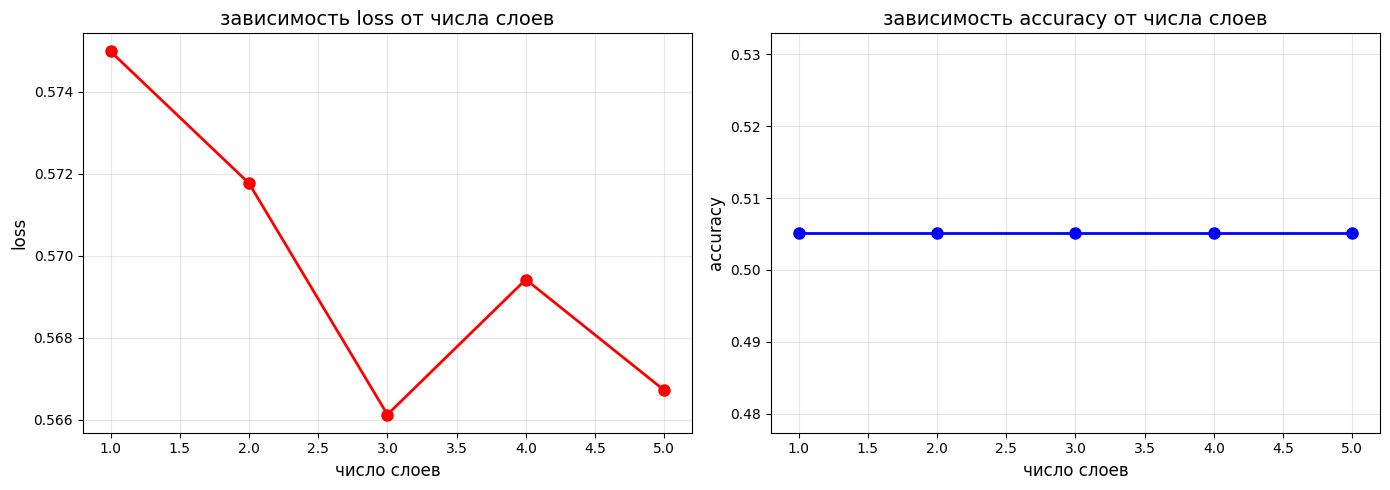

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

layers = [r['num_layers'] for r in results_layers]
losses = [r['final_loss'] for r in results_layers]
accs = [r['final_acc'] for r in results_layers]

axes[0].plot(layers, losses, 'ro-', linewidth=2, markersize=8)
axes[0].set_xlabel('число слоев', fontsize=12)
axes[0].set_ylabel('loss', fontsize=12)
axes[0].set_title('зависимость loss от числа слоев', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].plot(layers, accs, 'bo-', linewidth=2, markersize=8)
axes[1].set_xlabel('число слоев', fontsize=12)
axes[1].set_ylabel('accuracy', fontsize=12)
axes[1].set_title('зависимость accuracy от числа слоев', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [164]:
# 4.2
hidden_dims_list = [10, 20, 50, 100, 150, 200]
embedding_dim = 64
num_layers = 2
lr = 0.0001
epochs = 5

results_neurons = []

for hidden_dim in hidden_dims_list:
    model = GRUTask4(len(vocab2index), embedding_dim, hidden_dim, num_layers=num_layers)
    
    valid_losses, valid_accs = train_gru(model, train_loader, valid_loader, epochs, lr, verbose=True)
    
    results_neurons.append({
        'hidden_dim': hidden_dim,
        'final_loss': valid_losses[-1],
        'final_acc': valid_accs[-1],
        'valid_losses': valid_losses,
        'valid_accs': valid_accs
    })
    
    print(f"hidden_dim={hidden_dim}; loss={valid_losses[-1]}; accuracy={valid_accs[-1]}")
    
    del model
    torch.cuda.empty_cache()

Epoch 4: Valid Loss = 0.6115, Acc = 0.505
hidden_dim=10; loss=0.6114842941921749; accuracy=0.5051286803202683
Epoch 4: Valid Loss = 0.5870, Acc = 0.505
hidden_dim=20; loss=0.5869559099834957; accuracy=0.5051286803202683
Epoch 4: Valid Loss = 0.5692, Acc = 0.505
hidden_dim=50; loss=0.5691729033930918; accuracy=0.5051286803202683
Epoch 4: Valid Loss = 0.5606, Acc = 0.505
hidden_dim=100; loss=0.5606328712755375; accuracy=0.5051286803202683
Epoch 4: Valid Loss = 0.5636, Acc = 0.505
hidden_dim=150; loss=0.5636345265286692; accuracy=0.5051286803202683
Epoch 4: Valid Loss = 0.5587, Acc = 0.505
hidden_dim=200; loss=0.5587468105420638; accuracy=0.5051286803202683


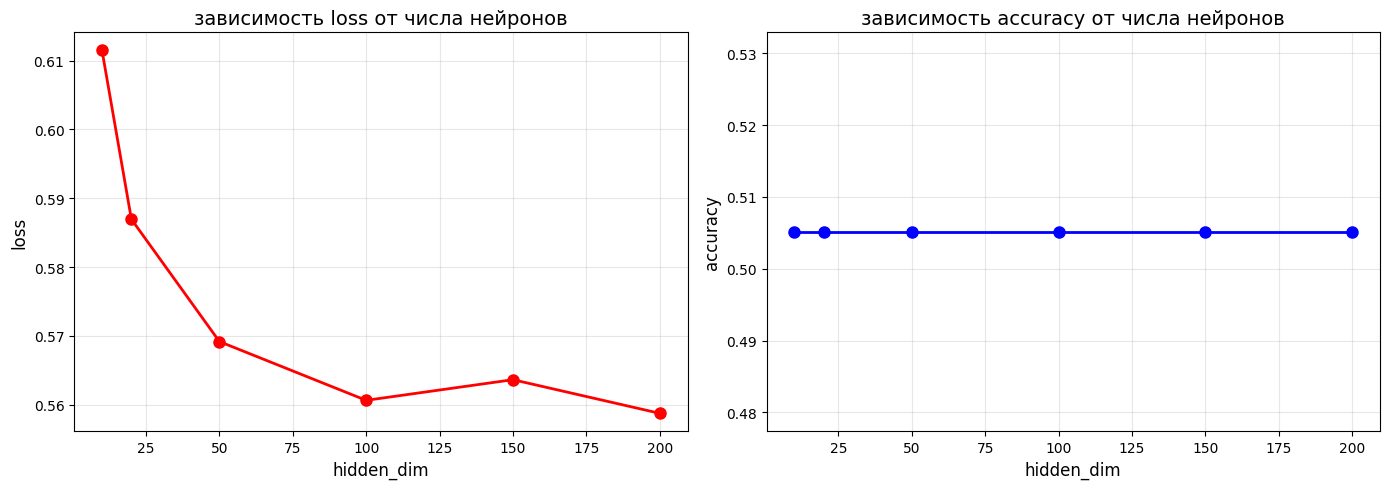

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

neurons = [r['hidden_dim'] for r in results_neurons]
losses = [r['final_loss'] for r in results_neurons]
accs = [r['final_acc'] for r in results_neurons]

axes[0].plot(neurons, losses, 'ro-', linewidth=2, markersize=8)
axes[0].set_xlabel('hidden_dim', fontsize=12)
axes[0].set_ylabel('loss', fontsize=12)
axes[0].set_title('зависимость loss от числа нейронов', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].plot(neurons, accs, 'bo-', linewidth=2, markersize=8)
axes[1].set_xlabel('hidden_dim', fontsize=12)
axes[1].set_ylabel('accuracy', fontsize=12)
axes[1].set_title('зависимость accuracy от числа нейронов', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 4.3
embedding_dim = 64
hidden_dim = 50
num_layers = 2
lr = 0.0001
epochs = 5

device_cpu = torch.device('cpu')
model_cpu = GRUTask4(len(vocab2index), embedding_dim, hidden_dim, num_layers=num_layers)

old_device = device
device = device_cpu

start_time = time.time()
valid_losses_cpu, valid_accs_cpu = train_gru(model_cpu, train_loader, valid_loader, epochs, lr)
cpu_time = time.time() - start_time

device = old_device
print(f"time CPU: {cpu_time} секунд")
del model_cpu

if torch.cuda.is_available():
    device_gpu = torch.device('cuda')
    model_gpu = GRUTask4(len(vocab2index), embedding_dim, hidden_dim, num_layers=num_layers)
    
    old_device = device
    device = device_gpu
    
    start_time = time.time()
    valid_losses_gpu, valid_accs_gpu = train_gru(model_gpu, train_loader, valid_loader, epochs, lr)
    gpu_time = time.time() - start_time
    
    device = old_device
    print(f"time GPU: {gpu_time} секунд")
    print(f"Прирост по времени в {cpu_time/gpu_time} раз")
    
    del model_gpu
    torch.cuda.empty_cache()
else:
    print("GPU недоступен")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [166]:
# 4.4
embedding_dims = [32, 64, 128]
hidden_dims = [20, 50, 100]
learning_rates = [0.0001, 0.001]

best_acc = 0
best_params = {}

epochs = 5

for emb_dim in embedding_dims:
    for hid_dim in hidden_dims:
        for lr in learning_rates:
            model = GRUTask4(len(vocab2index), emb_dim, hid_dim, num_layers=2)
            
            valid_losses, valid_accs = train_gru(model, train_loader, valid_loader, epochs, lr, verbose=False)
            
            final_acc = valid_accs[-1]
            final_loss = valid_losses[-1]
            
            if final_acc > best_acc:
                best_acc = final_acc
                best_params = {
                    'embedding_dim': emb_dim,
                    'hidden_dim': hid_dim,
                    'lr': lr
                }
            
            print(f"emb_dim={emb_dim}, hid={hid_dim}, lr={lr}, accuracy={final_acc}")
            
            del model
            torch.cuda.empty_cache()

emb_dim=32, hid=20, lr=0.0001, accuracy=0.5051286803202683
emb_dim=32, hid=20, lr=0.001, accuracy=0.5051286803202683
emb_dim=32, hid=50, lr=0.0001, accuracy=0.5051286803202683
emb_dim=32, hid=50, lr=0.001, accuracy=0.5051286803202683
emb_dim=32, hid=100, lr=0.0001, accuracy=0.5051286803202683
emb_dim=32, hid=100, lr=0.001, accuracy=0.5051286803202683
emb_dim=64, hid=20, lr=0.0001, accuracy=0.5051286803202683
emb_dim=64, hid=20, lr=0.001, accuracy=0.5051286803202683
emb_dim=64, hid=50, lr=0.0001, accuracy=0.5051286803202683
emb_dim=64, hid=50, lr=0.001, accuracy=0.5051286803202683
emb_dim=64, hid=100, lr=0.0001, accuracy=0.5051286803202683
emb_dim=64, hid=100, lr=0.001, accuracy=0.5051286803202683
emb_dim=128, hid=20, lr=0.0001, accuracy=0.5051286803202683
emb_dim=128, hid=20, lr=0.001, accuracy=0.5051286803202683
emb_dim=128, hid=50, lr=0.0001, accuracy=0.5051286803202683
emb_dim=128, hid=50, lr=0.001, accuracy=0.5051286803202683
emb_dim=128, hid=100, lr=0.0001, accuracy=0.505128680320

In [167]:
print(best_params)

{'embedding_dim': 32, 'hidden_dim': 20, 'lr': 0.0001}


In [168]:
print(best_acc)

0.5051286803202683


3 подхода:

<img src="images/RNNCompar.png">


Как регуляризовать?
- дропаут
- рекурентный дропаут


<img src="images/Dropouts.png">

In [ ]:
# Можно строить lstm с переменным размером входа:
class LSTM_variable_input(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)

    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

# Дополнительное задание:

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?



In [181]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

df_train = pd.read_csv("archive/train.csv")
df_test = pd.read_csv("archive/test.csv")

text_col = 'tweet'
label_col = 'label'

df_train.head()

Using device: cpu


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [182]:
def preprocess_text_english(txt):
    txt = str(txt).lower()
    txt = re.sub(r'http\S+|www\S+|https\S+', '', txt, flags=re.MULTILINE)
    txt = re.sub(r'@\w+', '', txt)
    txt = re.sub(r'#', '', txt)
    txt = re.sub(r'[^a-zA-Z\s]', '', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    return txt

df_train[text_col] = df_train[text_col].apply(preprocess_text_english)
df_test[text_col] = df_test[text_col].apply(preprocess_text_english)
df_train = df_train[df_train[text_col].str.len() > 0].reset_index(drop=True)
df_test = df_test[df_test[text_col].str.len() > 0].reset_index(drop=True)

In [183]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(
    df_train, test_size=0.2, random_state=42, stratify=df_train[label_col]
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.25, random_state=42, stratify=train_val_df[label_col]
)

text_corpus_train = train_df[text_col].values
text_corpus_val = val_df[text_col].values
text_corpus_test = test_df[text_col].values

In [184]:
counts = Counter()
for sequence in text_corpus_train:
    counts.update(sequence.split())

for word in list(counts):
    if counts[word] < 2:
        del counts[word]

vocab2index = {"UNK": 1}
words = ["UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

print(f"vocab size: {len(vocab2index)}")

vocab size: 10426


In [185]:
y_train = train_df[label_col].values
y_val = val_df[label_col].values
y_test = test_df[label_col].values

seq_lengths = [len(txt.split()) for txt in text_corpus_train]
seq_length = np.max(seq_lengths)

batch_size = 128
num_workers = 0

train_dataset = TwitterDataset(text_corpus_train, y_train, vocab2index, seq_length)
valid_dataset = TwitterDataset(text_corpus_val, y_val, vocab2index, seq_length)
test_dataset = TwitterDataset(text_corpus_test, y_test, vocab2index, seq_length)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [186]:
embedding_dims = [64, 128, 256]
hidden_dims = [20, 50, 100]
learning_rates = [0.0001, 0.001]

best_acc = 0
best_params = {}

epochs = 5

for emb_dim in embedding_dims:
    for hid_dim in hidden_dims:
        for lr in learning_rates:
            model = LSTMTask3(len(vocab2index), emb_dim, hid_dim, num_layers=2)
            
            valid_losses, valid_accs = train_lstm(model, train_loader, valid_loader, epochs, lr, verbose=False)
            
            final_acc = valid_accs[-1]
            final_loss = valid_losses[-1]
            
            if final_acc > best_acc:
                best_acc = final_acc
                best_params = {
                    'embedding_dim': emb_dim,
                    'hidden_dim': hid_dim,
                    'lr': lr
                }
            
            print(f"emb_dim: {emb_dim}; hid_dim: {hid_dim}; lr: {lr}; accuracy: {final_acc} loss: {final_loss:.4f}")
            
            del model
            torch.cuda.empty_cache()

emb_dim: 64; hid_dim: 20; lr: 0.0001; accuracy: 0.9298077964782715 loss: 0.9820
emb_dim: 64; hid_dim: 20; lr: 0.001; accuracy: 0.9083487915992737 loss: 0.2220
emb_dim: 64; hid_dim: 50; lr: 0.0001; accuracy: 0.9298229169845581 loss: 0.3713
emb_dim: 64; hid_dim: 50; lr: 0.001; accuracy: 0.9214526212215424 loss: 0.2148
emb_dim: 64; hid_dim: 100; lr: 0.0001; accuracy: 0.9298229169845581 loss: 0.2551
emb_dim: 64; hid_dim: 100; lr: 0.001; accuracy: 0.9298588728904724 loss: 0.2151
emb_dim: 128; hid_dim: 20; lr: 0.0001; accuracy: 0.9279314506053925 loss: 0.9163
emb_dim: 128; hid_dim: 20; lr: 0.001; accuracy: 0.9064650523662567 loss: 0.2216
emb_dim: 128; hid_dim: 50; lr: 0.0001; accuracy: 0.9298229169845581 loss: 0.3237
emb_dim: 128; hid_dim: 50; lr: 0.001; accuracy: 0.9256223130226136 loss: 0.2218
emb_dim: 128; hid_dim: 100; lr: 0.0001; accuracy: 0.9299492573738098 loss: 0.2479
emb_dim: 128; hid_dim: 100; lr: 0.001; accuracy: 0.9250379717350006 loss: 0.2146
emb_dim: 256; hid_dim: 20; lr: 0.000

In [187]:
print(best_params)
print(best_acc)

{'embedding_dim': 256, 'hidden_dim': 100, 'lr': 0.0001}
0.9300349414348602


In [188]:
model = LSTMTask3(len(vocab2index), 256, 100, num_layers=2)
valid_losses, valid_accs = train_lstm(model, train_loader, valid_loader, epochs, lr, verbose=False)

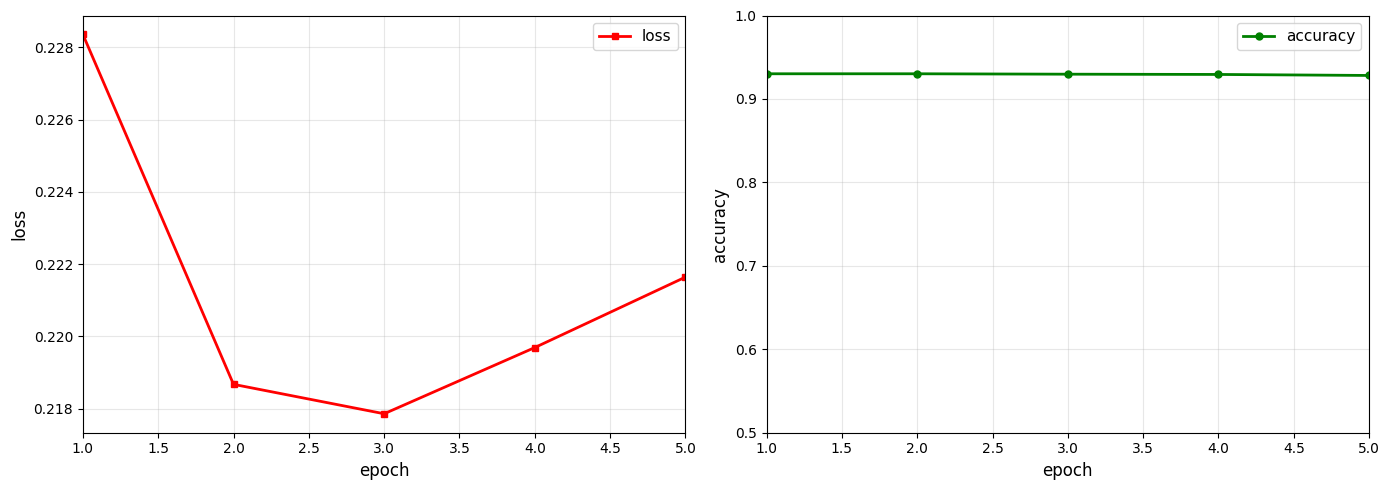

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, epochs+1), valid_losses, 'r-', linewidth=2, marker='s', markersize=5, label='loss')
axes[0].set_xlabel('epoch', fontsize=12)
axes[0].set_ylabel('loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(1, epochs)

axes[1].plot(range(1, epochs+1), valid_accs, 'g-', linewidth=2, marker='o', markersize=5, label='accuracy')
axes[1].set_xlabel('epoch', fontsize=12)
axes[1].set_ylabel('accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(1, epochs)
axes[1].set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

#### Вывод по доп. заданию

Модель смогла достичь точности в 93%, что говорит о хорошем качестве классификации.
Точность помогло повысить увеличение размерности эмбеддинга, что логично, т.к. у каждого текста становится больше скрытых признаков, а значит и качество классификации улучшается. Также помогло увеличение размерности скрытого состояния - вектора памяти h. Это тоже логично, т.к. модель может хранить больше информации. Также небольшой lr позволяет не прыгать и стабильно обучаться.

Вопросы:

А. Зачем испoльзуют рекуррентные сети:

  1. для сокращения времени обучения
  2. для борьбы с исчезновением градиента
  3. для использования контекста

В. В чем проблема "ванильных"  рекуррентных сетей:

  1. большое время для обучения
  2. Исчезновение градиента
  3. отсутствие методов обучения

С. Какую проблему решает LSTM:

  1. сокращение времени обучения
  2. борьба с исчезновением градиента
  3. использование контекста

D. Какую проблему решает GRU:

  1. сокращение времени обучения
  2. борьба с исчезновением градиента
  3. использование контекста

Е. Какие узлы позволяют решать более точно задачи (в среднем):
  1. LSTM
  2. RNN
  3. GRU  